# Image Descriptors and Corner Detection

In this notebook I experiemnt with:
* Practising with different keypoint detectors and image descriptors
* Applying image descriptors in image matching

Import the OpenCV & Numpy Libraries and read in refere4nce image

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

img = cv.imread('./resources/empire.jpg')

## 1. Harris Corver Detection

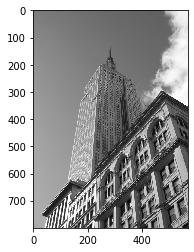

In [2]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(img_gray, 'gray')

Specify some parameters for the Harris Corner detection method

In [3]:
local_region_size = 3
kernel_size = 3
k = 0.04
threshold = 1000.0

Convert the image intensity values to floats

In [4]:
img_gray = np.float32(img_gray)

Use the cornerHarris() method from OpenCV

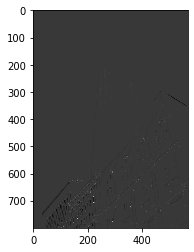

In [5]:
harris_res_img = cv.cornerHarris(img_gray, local_region_size, kernel_size, k)
plt.imshow(harris_res_img, 'gray')

Select the hightlight colour for displaying the detected corners. I chose green to make it very visible

True

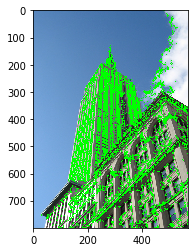

In [6]:
highlighted_colour = [0, 255, 0]
highlighted_img = img.copy()
highlighted_img[harris_res_img > threshold] = highlighted_colour
plt.imshow(highlighted_img[:,:,::-1])
cv.imwrite('hcd_1000.png', highlighted_img)

Count the number of detected corners greater than the threshold. This can be accomplished with 2 for loops looping over each pixel and checking it against the threshold condition. The below fuinction accomplishses this.

In [7]:
def cornerCount(img, cnr_threshold):
    height, width = img.shape
    count = 0
    for i in range(0, height):
        for j in range(0, width):
            if img[i,j] > cnr_threshold:
                count += 1
           
    return count

In [8]:
cornerCount(harris_res_img, threshold)

87282

To check the threshold you can also perform a np.count whichy is a little more simplified in its syntax.

In [9]:
np.count_nonzero(highlighted_img[harris_res_img > threshold])

87282

To test this with a few different combinations and thresholds, you can wrap the streps into a function the performs all the subsequent steps and returns the results.

In [10]:
def cornerDetect(img, local_region_size, kernel_size, k, cnr_threshold, highlighted_colour):
    """
    Performs harris corner detection and returns and image with the highlighted corners in "highlight_colour"
    and a count of corners detected.
    """
    
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    img_gray = np.float32(img_gray)
    harris_img = cv.cornerHarris(img_gray, local_region_size, kernel_size, k)
    
    highlighted_img = img.copy()
    highlighted_img[harris_img > cnr_threshold] = highlighted_colour
    
    corner_count = np.count_nonzero(highlighted_img[harris_res_img > threshold])
    
    return highlighted_img, corner_count

## Threshold 1000

In [11]:
highlighted_colour = [0, 255, 0]
threshold = 1000.0

thresh_1000_img, thresh_1000_corner_count = cornerDetect(img, local_region_size, 
                                                       kernel_size, k, threshold, 
                                                       highlighted_colour)
thresh_1000_corner_count

87282

## Test with a range of thresholds and see the results

I performed Harris Corner Detection with various thresholds to observer the change and relationship between the threshold and corners detected.

In [12]:
thresholds = [10, 50, 100, 500, 1000, 2000, 5000, 7500, 10000, 15000]

In [13]:
columns = ['threshold' , 'corners']
corners_df = pd.DataFrame(columns=columns)

for threshold in thresholds:
    _, corner_count = cornerDetect(img, local_region_size, 
                                   kernel_size, k, threshold, 
                                   highlighted_colour)
    corners_df = corners_df.append({'threshold' : threshold , 'corners' : corner_count} , ignore_index=True)

In [14]:
corners_df

,threshold,corners
0,10,119960
1,50,108879
2,100,104083
3,500,92540
4,1000,87282
5,2000,81612
6,5000,73167
7,7500,69144
8,10000,66129
9,15000,61801


I observed an inverse or negative correlation between threshold and corners detected. 

The highest number of corners was detected when using the lowest threshold (10) and the least corners detected using the highest threshold (15000). This can be visualised in the plot below.

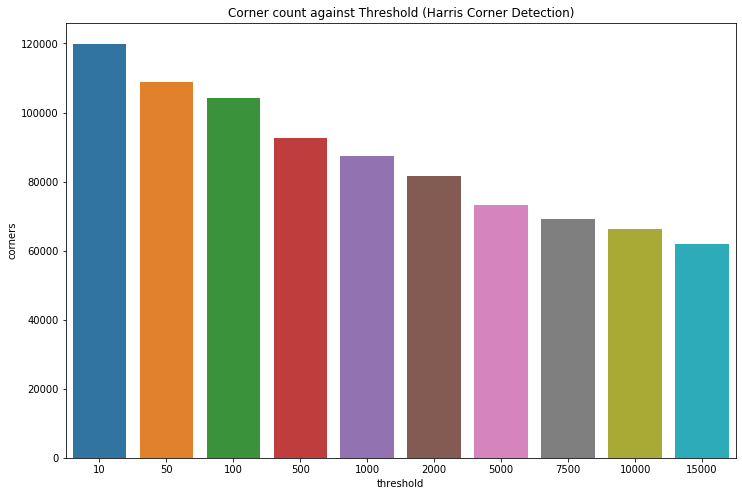

In [15]:
plt.figure(figsize=(12,8))
plt.title("Corner count against Threshold (Harris Corner Detection)")
sns.barplot(x='threshold', y='corners', data=corners_df)
plt.savefig('thresholds.png')

## 2. SIFT

In [16]:
sift = cv.xfeatures2d.SIFT_create()

The below code only works in 3.4.2.x. Check the version before continuing.

In [17]:
cv.__version__

'3.4.2'

### 2.1 Key point detection

In [18]:
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

kp = sift.detect(img_gray, None)

Draw and count keypoints

Number of detected keypoints: 2804


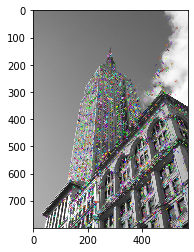

In [19]:
img_gray_kp = img_gray.copy()
img_gray_kp = cv.drawKeypoints(img_gray, kp, img_gray_kp)
plt.imshow(img_gray_kp)
plt.savefig('keypoints.png')


print(f"Number of detected keypoints: {len(kp)}" )

Display local image regions used for SIFT

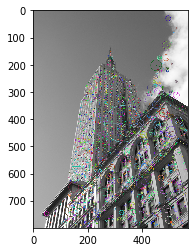

In [20]:
img_gray_kp = cv.drawKeypoints(img_gray, kp, img_gray_kp, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(img_gray_kp)

### 2.2 Descriptor Computation

In [21]:
kp, des = sift.compute(img_gray, kp)
print(des.shape)

(2804, 128)


### 2.3 Abalation Study

In [22]:
img_45 = cv.imread('./resources/empire_45.jpg')
img_zoomedout = cv.imread('./resources/empire_zoomedout.jpg')
img_45_gray = cv.cvtColor(img_45, cv.COLOR_BGR2GRAY)
img_zoomedout_gray = cv.cvtColor(img_zoomedout, cv.COLOR_BGR2GRAY)
img_another = cv.imread('./resources/fisherman.jpg')
img_another_gray = cv.cvtColor(img_another, cv.COLOR_BGR2GRAY)

In [23]:
kp_45, des_45 = sift.detectAndCompute(img_45_gray, None)
kp_zoomedout, des_zoomedout = sift.detectAndCompute(img_zoomedout_gray, None)
kp_another, des_another = sift.detectAndCompute(img_another_gray, None)

In [24]:
print(f"The number of keypoints in img_gray is {len(des)}")
print(f"The number of keypoints in img_45_gray is {len(des_45)}")

The number of keypoints in img_gray is 2804
The number of keypoints in img_45_gray is 3290


In [25]:
from scipy.spatial.distance import directed_hausdorff

The Hausdorff distance was measured between the reference image and each of the comparative images.

In [26]:
print(f"""
des v des_45: {directed_hausdorff(des, des_45)[0]:.2f}
des v des_zoomedout: {directed_hausdorff(des, des_zoomedout)[0]:.2f}
des v des_another: {directed_hausdorff(des, des_another)[0]:.2f}
""")


des v des_45: 399.88
des v des_zoomedout: 401.34
des v des_another: 433.90



Upon computing the Hausdorrff Distance between each image pair, the empire.jpg vs empire_45.jpg comparison resulted in the lowest Hausdorff Distance. 

This was closely followed by empire.jpg vs empire_zoomedout.jpg. This is unsurprising given they are the same images with small transformations. For empire.jpg vs fisherman.jpg, you can see the Hausdorff Distance is quiet different from the other results. This is also expected given they are 2 completely different images and contain different features.